In [1]:
from torch import nn
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
from numpy import loadtxt
from PIL import Image
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

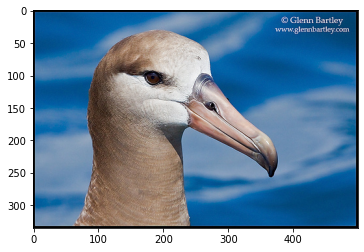

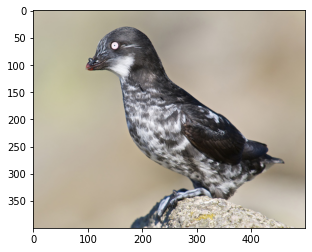

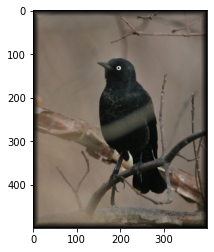

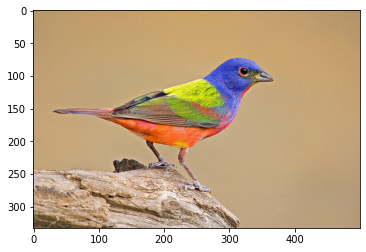

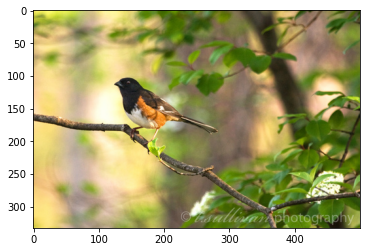

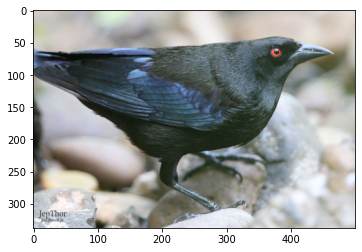

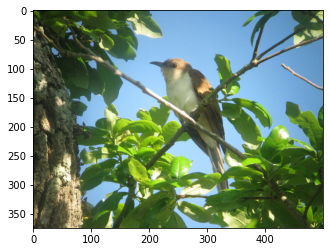

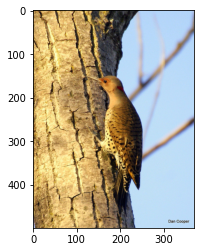

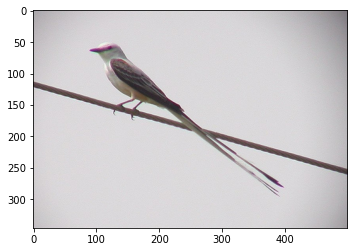

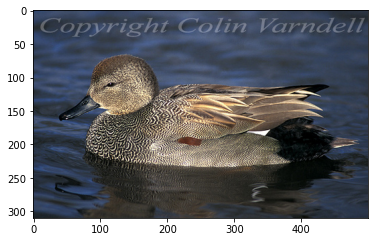

In [2]:
def cub_subset(n = 4):
    """
    Function to read subset of birds dataset CUB_200_2011
    n : n images per class
    """
    cub_folder = 'vs3ex1data/CUB_200_2011/'
    f = open(cub_folder + "images.txt", 'r')
    cub_imgfn = [a.split(' ')[::-1] for a in f.read().split('\n')]
    cub_label = loadtxt(cub_folder + "image_class_labels.txt", delimiter=" ", unpack=False)[:,1].astype(int) - 1
    sub_idx = []
    for i in range(0,max(cub_label)+1):
        sub_idx = sub_idx + ([x for (x,val) in enumerate(cub_label) if val == i][0:n])
        
    cub_img = [(cub_folder+'/jpg/'+cub_imgfn[x][0]) for x in sub_idx]
    cub_label = np.array([cub_label[x] for x in sub_idx])
    
    return cub_img, cub_label


# get images and labels for CUB subset
cub_img, cub_label = cub_subset()

# show sample images
for i in range(0,200,20):
    plt.imshow(Image.open(cub_img[i]))
    plt.show
    plt.pause(0.1)

In [3]:
def l2n(x, eps=1e-6):
    """
    Vector L2 normalization 
    """
    return x / (torch.norm(x, p=2, dim=1, keepdim=True) + eps).expand_as(x)

class EmbNet(nn.Module):
    """
    Create network that maps an image to an embedding (descriptor) 
    """    
    def __init__(self, input_net, n = 3):
        """
        Contructor takes another network (input_net) as input
        input_net: assumed to have features and classifier fields (eg AlexNet, VGG, ...)
        n: keep unitl n-th layer of the classifier 
        """
        super(EmbNet, self).__init__()
        self.features = input_net.features
        self.classifier = nn.Sequential(*list(input_net.classifier[0:n+1]));  # keep until n-th layer

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))
        x = self.classifier(x)
        return l2n(x)

model = torchvision.models.alexnet(pretrained = True) # load pre-trained model
print(model)

# image transformation 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
scale = transforms.Resize([224,224])
tote = transforms.ToTensor()
comptran = transforms.Compose([scale,tote,normalize])

last_layer = 1  # of the classifier part
getdescriptor = EmbNet(model, last_layer) # construct the network that extracts descriptors 
getdescriptor.eval()   # put network in evaluation mode
print(getdescriptor)

# extact descriptors for all images
print('Extracting descriptors...')
des = torch.Tensor()
for i in range(0, len(cub_img)):
    with torch.no_grad():
        des = torch.cat((des, getdescriptor((comptran(Image.open(cub_img[i])).unsqueeze(0)))))
print('Finished with extracting descriptors...')

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
def test(descriptors, labels):
    """
    Evaluate descriptors on retrieval
    """
    # compute all pair-wise distances
    cdistances = cdist(descriptors.data.numpy(), descriptors.data.numpy(), 'euclidean')

    # find rank of closest positive image (using each descriptor as a query)
    minrank_positive = []
    for i in range(0,len(cdistances)):
        idx = np.argsort(cdistances[i])
        minrank_positive.append( np.min([j for (j,x) in enumerate(labels[idx[1:-1]]) if x==labels[i]]) )

    print('At-least-1-positive@1   : {:.3f}'.format((np.array(minrank_positive)<1).mean()))
    print('At-least-1-positive@5   : {:.3f}'.format((np.array(minrank_positive)<5).mean()))
    print('At-least-1-positive@10  : {:.3f}'.format((np.array(minrank_positive)<10).mean()))

# evaluate the descriptors in a retrieval task 
test(des, cub_label)

At-least-1-positive@1   : 0.141
At-least-1-positive@5   : 0.354
At-least-1-positive@10  : 0.453


In [9]:
class EmbNetGP(nn.Module):
    """
    Create network that maps an image to an embedding (descriptor) with global pooling
    """    
    def __init__(self, input_net):
        """
        Contructor takes another network (input_net) as input
        input_net: assumed to have features and classifier fields (eg AlexNet, VGG, ...)
        n: keep unitl n-th layer of the classifier 
        """
        super(EmbNetGP, self).__init__()
        self.features = input_net.features
        self.pool = nn.AvgPool2d(5)

    def forward(self, x):
           
        ### YOUR CODE HERE
        x = self.features(x)
        x = self.pool(F.relu(x))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        return l2n(x)
    
getdescriptor = EmbNetGP(model) # construct the network that extracts descriptors 
getdescriptor.eval()   # put network in evaluation mode

# extact descriptors for all images
print('Extracting descriptors...')
des = torch.Tensor()
for i in range(0, len(cub_img)):
    with torch.no_grad():
        des = torch.cat((des, getdescriptor((comptran(Image.open(cub_img[i])).unsqueeze(0)))))
print('Finished with extracting descriptors...')

# evaluate the descriptors in a retrieval task 
test(des, cub_label)    

Extracting descriptors...
Finished with extracting descriptors...
At-least-1-positive@1   : 0.185
At-least-1-positive@5   : 0.399
At-least-1-positive@10  : 0.507
